<a href="https://colab.research.google.com/github/haldrianmit/CatKit/blob/master/advanced_kinetics_qm_tut_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Install Conda Colab**
# @markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [ ]:
#@title **Install dependencies**
# @markdown This will take a few minutes.
# install dependencies
%%capture
!mamba install -c anaconda intel-openmp
!conda config --add channels http://conda.anaconda.org/psi4
!mamba install psi4 resp -c conda-forge/label/libint_dev -c conda-forge

import os
import psi4
import resp

In [ ]:
import numpy as np
#We're going to explore the formaldehyde dissociation reaction as an example in this tutorial.
#First, we will set the memory usage for the psi4 program and define some geometries. Note that psi4 uses Bohr by default.

psi4.set_memory('500 MB')

co = psi4.geometry("""
C       -3.69588       -0.86528        0.00000
O       -3.82425        0.18390        0.00000
""")

h2 = psi4.geometry("""
H       -4.75453       -0.43223        0.00000
H       -4.76313       -1.14018        0.00000
""")

formaldehyde = psi4.geometry("""
C         -4.91148       -0.76497        0.02838
O         -4.94682        0.45913        0.02244
H         -5.82601       -1.37924        0.03603
H         -3.96304       -1.32551        0.02644
""")

In [ ]:
#Let's start with some simple single-point energy calculations. These don't alter the geometry to be a minimum at the same level of theory, but just return the corresponding energy of the input geometry.
co_hf_e = psi4.energy('scf/cc-pvdz', molecule = co)
print(f"The HF/cc-pVDZ energy of CO is {co_hf_e} Hartrees")

The HF/cc-pVDZ energy of CO is -112.74116680632797 Hartrees


In [ ]:
#Likewise, we next do the same for the other species:

h2_hf_e = psi4.energy('scf/cc-pvdz', molecule = h2)
print(f"The HF/cc-pVDZ energy of H2 is {h2_hf_e} Hartrees")

formald_hf_e = psi4.energy('scf/cc-pvdz', molecule = formaldehyde)
print(f"The HF/cc-pVDZ energy of formaldehyde is {formald_hf_e} Hartrees")

The HF/cc-pVDZ energy of H2 is -1.127504675923623 Hartrees
The HF/cc-pVDZ energy of formaldehyde is -113.87383563634836 Hartrees


In [ ]:
#These species are small enough that reference calculations are out there. If you check reference values, you will notice that the above energies are slightly different to those reported at the same level of theory.
#As for why, the geometries above are from a simple force-field, so they are not the same as minima on the HF surface.
#To find the geometry corresponding to a mininum on the potential energy surface at our given level of theory, we need to perform an optimization:

psi4.optimize('scf/cc-pvdz', molecule=co) #Find the minimum energy geometry on the HF/cc-pVDZ surface.

Optimizer: Optimization complete!


-112.74990561229222

In [ ]:
#As the energy went down, the geometry will have changed. Let's take a look at it:

for iat in range(co.natom()):
    print(

                                  co.symbol(iat),  # element symbol
                                  co.x(iat),       # x-coordinate
                                  co.y(iat),       # y-coordinate
                                  co.z(iat),       # z-coordinate
                                  co.mass(iat),    # mass
)

C 9.30371222e-315 0.0 -1.19857731953546 12.0
O -6.980002663e-315 0.0 0.8992187940051777 15.99491461957


In [ ]:
#The geometries in Psi4 are in atomic units (Bohr), whereas Angstrom is more often used. Let's scale the geometry accordingly:
co_geom = co.geometry()
co_geom.scale(0.52917720859) #convert to angstroms
co_geom_array = co_geom.to_array() #make a numpy array that we can store/manipulate etc.
co_geom_array

array([[ 0.00000000,  0.00000000, -0.63425980],
       [-0.00000000,  0.00000000,  0.47584609]])

In [ ]:
#We saw above that the geometry did change as we'd expect. Now we can proceed to perform optimizations for hydrogen and formaldehyde as well.
psi4.optimize('scf/cc-pvdz', molecule=h2)

Optimizer: Optimization complete!


-1.1287470112295486

In [ ]:
psi4.optimize('scf/cc-pvdz', molecule=formaldehyde) #Note that calling optimize updates the geometry associated with the molecule object, so no need to reassign unless you want to preserve the original geometry.

	Energy has increased in a minimization.
	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to 2.500e-01.


Optimizer: Optimization complete!


-113.87703230030127

In [ ]:
#So far we have done single-point and geometry optimizations. This gives us an SCF energy that is relative to a reference state of independent particles and is not governed by temperature
#It's in effect a 0K energy. For actual thermodynamic and kinetic parameters, we want enthalpies, free energies and the like at a finite temperature like 298 K.
#To do this, we need to apply thermal corrections for translational, rotational, and vibrational degrees of freedom through the partition functions.
# For the latter, we need to do frequency calculations. These compute second derivatives of the energy at a given geometry and such are only well defined when your geometry and frequency levels of theory match.

co_e, co_wfn = psi4.frequency('scf/cc-pvdz', molecule=co, return_wfn=True) #Store the energy and wavefunction for later analysis
print(co_e) #print the energy of CO just to make sure nothing too odd is going on.

-112.74990561229676


In [ ]:
#We will also check the value of our frequency. For minima on the potential energy surface, we should see no imaginary (may show as negative in some codes) frequencies.
#If you do see imaginary frequencies, this means that the optimization was not successful.
for ifreq in range(int(3*co.natom() - 5)):
    print(co_wfn.frequencies().get(0,ifreq))

2431.780533240022


In [ ]:
#With this, we can compute some thermodynamic properties. First we call vibrational analysis in Psi4:
co_vibinfo = psi4.driver.vibanal_wfn(co_wfn)

In [ ]:
#Next, we compute the thermodynamic information. We need to provide a few inputs to the driver for it compute everything.
#All of this except for the molecular weight can be taken directly from the molecule object.

#Compute molecular weight of co:
co_mol_mass = 0
for iat in range(co.natom()):
    co_mol_mass += co.mass(iat)



T = 298.15
P = 101325
co_mult = co.multiplicity()
co_sigma = co.rotational_symmetry_number()
co_rot_constants = np.asarray(co.rotational_constants())

co_therminfo = psi4.driver.qcdb.vib.thermo(co_vibinfo, T, P, co_mult, co_mol_mass, co_e, co_sigma, co_rot_constants , "RT_LINEAR") #Note that we pass an argument to tell Psi4 the molecule is linear for the rotational partition function.
co_thermdict = co_therminfo[0] #Give us our dictionary of thermodynamic values
co_thermdict

{'E0': Datum(numeric=True, label='E0', units='Eh', data=-112.74990561229676, comment='', doi=None, glossary=''),
 'B': Datum(numeric=True, label='rotational constants', units='cm^-1', data=array([ 0.00000000,  1.99518721,  1.99518721]), comment='', doi=None, glossary=''),
 'sigma': Datum(numeric=True, label='external symmetry number', units='', data=1, comment='', doi=None, glossary=''),
 'T': Datum(numeric=True, label='temperature', units='K', data=298.15, comment='', doi=None, glossary=''),
 'P': Datum(numeric=True, label='pressure', units='Pa', data=101325, comment='', doi=None, glossary=''),
 'S_elec': Datum(numeric=True, label='electronic S', units='mEh/K', data=0.0, comment='', doi=None, glossary=''),
 'S_trans': Datum(numeric=True, label='translational S', units='mEh/K', data=0.05724692326015637, comment='', doi=None, glossary=''),
 'Cv_trans': Datum(numeric=True, label='translational Cv', units='mEh/K', data=0.004750215737277949, comment='', doi=None, glossary=''),
 'Cp_trans':

In [ ]:
#The dictionary contains plenty of thermodynamic information that can be useful. The parameter we are interested in here is the Gibbs Free Energy:
co_thermdict['G_tot']

Datum(numeric=True, label='total G', units='Eh', data=-112.76345723536996, comment='', doi=None, glossary='')

In [ ]:
#Get the thermochemistry data for H2:

h2_e, h2_wfn = psi4.frequency('scf/cc-pvdz', molecule=h2, return_wfn=True) #Store the energy and wavefunction for later analysis

h2_vibinfo = psi4.driver.vibanal_wfn(h2_wfn) # do the vibrational analysis for H2

h2_mol_mass = 0
for iat in range(h2.natom()):
    h2_mol_mass += h2.mass(iat)

T = 298.15
P = 101325
h2_mult = h2.multiplicity()
h2_sigma = h2.rotational_symmetry_number()
h2_rot_constants = np.asarray(h2.rotational_constants())

h2_therminfo = psi4.driver.qcdb.vib.thermo(h2_vibinfo, T, P, h2_mult, h2_mol_mass, h2_e, h2_sigma, h2_rot_constants , "RT_LINEAR") #Note that we pass an argument to tell Psi4 the molecule is linear
h2_thermdict = h2_therminfo[0] #Give us our dictionary of thermodynamic values

In [ ]:
#Get the thermochemistry data for formaldehyde:

formald_e, formald_wfn = psi4.frequency('scf/cc-pvdz', molecule=formaldehyde, return_wfn=True) #Store the energy and wavefunction for later analysis

formald_vibinfo = psi4.driver.vibanal_wfn(formald_wfn) # do the vibrational analysis for H2

formald_mol_mass = 0
for iat in range(formaldehyde.natom()):
    formald_mol_mass += formaldehyde.mass(iat)

T = 298.15
P = 101325
formald_mult = formaldehyde.multiplicity()
formald_sigma = formaldehyde.rotational_symmetry_number()
formald_rot_constants = np.asarray(formaldehyde.rotational_constants())

formald_therminfo = psi4.driver.qcdb.vib.thermo(formald_vibinfo, T, P, formald_mult, formald_mol_mass, formald_e, formald_sigma, formald_rot_constants) #Note that we don't specify rot_type. Nonlinear is the default.
formald_thermdict = formald_therminfo[0] #Give us our dictionary of thermodynamic values

In [ ]:
#We can now compute an equilibrium constant for the formaldehyde reaction using the reaction free energy:
co_g = co_thermdict['G_tot'].data
h2_g = h2_thermdict['G_tot'].data
formald_g = formald_thermdict['G_tot'].data

R = 1.987*10**(-3) # in kcal/molK
ha_to_kcal = 627.509 #conversion factor to kcal/mol, a more familiar unit to us.
del_g_r = (formald_g - (co_g + h2_g)) * ha_to_kcal
eq_r = np.exp(- del_g_r / (R * T))
eq_r

1.7507827351225656e-11

In [ ]:
#So we aren't worried about CO poisoning from formaldehyde decomposition at room temperature.
#As we know, the equilibrium constant will be a function of temperature, so let's compute the equilibrium constant at multiple temperatures.
#Let's define some functions to expedite proceedings.

def optfreq(mol, method, basis_set):
    #First, do the optimization.
    psi4.optimize(method + '/' + basis_set , molecule=mol)

    #Then compute the frequencies using this geometry.
    mol_e, mol_wfn = psi4.frequency(method + '/' + basis_set , molecule = mol, return_wfn=True)

    #Next do the vibrational analysis.
    mol_vibinfo = psi4.driver.vibanal_wfn(mol_wfn) # do the vibrational analysis for the molecule.
    return mol_e, mol_wfn, mol_vibinfo

def thermocalc(mol, mol_vibinfo, T, P, mol_e, mol_shape = None):
    #Compute the molar mass for the molecule:
    mol_mass = 0
    for iat in range(mol.natom()):
        mol_mass += mol.mass(iat)

    #Get all the other molecular information required for the thermo_calculations.
    mol_mult = mol.multiplicity()
    mol_sigma = mol.rotational_symmetry_number()
    mol_rot_constants = np.asarray(mol.rotational_constants())

    #Next compute the thermo:
    mol_therminfo_T = psi4.driver.qcdb.vib.thermo(mol_vibinfo, T, P, mol_mult, mol_mass, mol_e, mol_sigma, mol_rot_constants , mol_shape)
    mol_thermdict_T = mol_therminfo_T[0]

    return mol_thermdict_T

def compute_eq_constant(reactant_thermdicts, product_thermdicts):
    R = 1.987*10**(-3) # in kcal/molK
    ha_to_kcal = 627.509

    Temps = [thermdict['T'].data  for thermdict in reactant_thermdicts + product_thermdicts]
    assert(len(set(Temps)) == 1)

    reac_g = sum(thermdict['G_tot'].data  for thermdict in reactant_thermdicts)
    prod_g = sum(thermdict['G_tot'].data  for thermdict in product_thermdicts)


    del_g_r = (prod_g - reac_g) * ha_to_kcal
    eq_r = np.exp(- del_g_r / (R * Temps[0]))
    return eq_r

In [ ]:
eq_rs = []

Ts = [300, 500, 800, 1000, 1400, 2000]

for T in Ts:
  co_thermdict_T = thermocalc(co, co_vibinfo, T, 101325, co_e, 'RT_LINEAR')
  h2_thermdict_T = thermocalc(h2, h2_vibinfo, T, 101325, h2_e, 'RT_LINEAR')
  formald_thermdict_T = thermocalc(formaldehyde, formald_vibinfo, T, 101325, formald_e)
  eq_r = compute_eq_constant([co_thermdict_T, h2_thermdict_T], [formald_thermdict_T])
  eq_rs.append(eq_r)

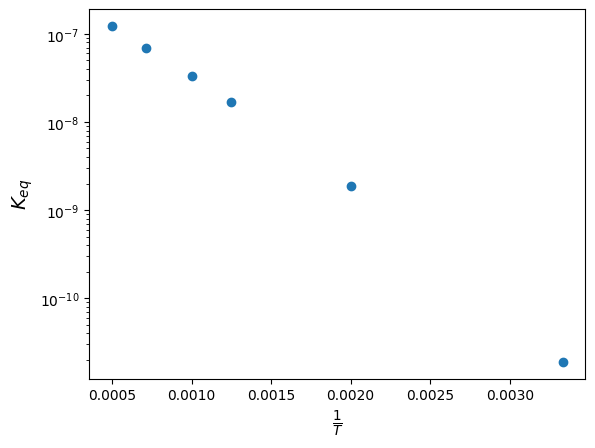

In [ ]:
from matplotlib import pyplot as plt
#plot the equilibrium constant as a function of temperature
T_invs = [1/T for T in Ts]
plt.figure()
plt.plot(T_invs, eq_rs ,'o')
plt.yscale('log')
plt.xlabel(r"$\frac{1}{T}$", fontsize = 14)
plt.ylabel("$K_{eq}$", fontsize = 14)
plt.show()


In [ ]:
#Hartree-Fock theory is a very basic method, being the simplest wavefunction and including no electron correlation whatsoever. Let's try a density functional theory (DFT) method next.
#We'll try a common generalized gradient approximation (GGA) functional in B971. GGA functionals are a popular category of pure functionals (particularly if you do periodic/plane-wave DFT on larger systems).
#The functionals in DFT are parameterized to try and include some correlation energy effects that simple HF will not whilst also computing the exchange energy effects (which HF computes exactly).
#Let's start with CO :

co_dft_e, co_dft_wfn, co_dft_vibinfo = optfreq(co, 'B97-1', 'cc-pvdz')
co_dft_thermdict = thermocalc(co, co_dft_vibinfo, 298.15, 101325, co_dft_e, 'RT_LINEAR')


Optimizer: Optimization complete!


In [ ]:
#Repeat for H2.
h2_dft_e, h2_dft_wfn, h2_dft_vibinfo = optfreq(h2, 'B97-1', 'cc-pvdz')
h2_dft_thermdict = thermocalc(h2, h2_dft_vibinfo, 298.15, 101325, h2_dft_e, 'RT_LINEAR')

Optimizer: Optimization complete!


In [ ]:
#And for formaldehyde.
formald_dft_e, formald_dft_wfn, formald_dft_vibinfo = optfreq(formaldehyde, 'B97-1', 'cc-pvdz')
formald_dft_thermdict = thermocalc(formaldehyde, formald_dft_vibinfo, 298.15, 101325, formald_dft_e)

	Energy has increased in a minimization.
	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to 2.500e-01.
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 8.07e-09



Optimizer: Optimization complete!


In [ ]:
#Let's compute the equilibrium constant at the new level of theory:
eq_dft_rs = []
for T in Ts:
  co_thermdict_dft = thermocalc(co, co_dft_vibinfo, T, 101325, co_dft_e, 'RT_LINEAR')
  h2_thermdict_dft = thermocalc(h2, h2_dft_vibinfo, T, 101325, h2_dft_e, 'RT_LINEAR')
  formald_thermdict_dft = thermocalc(formaldehyde, formald_dft_vibinfo, T, 101325, formald_dft_e)
  eq_dft_r = compute_eq_constant([co_thermdict_dft, h2_thermdict_dft], [formald_thermdict_dft])
  eq_dft_rs.append(eq_dft_r)

In [ ]:
print(co_dft_e, h2_dft_e, formald_dft_e)

-113.29162270762106 -1.1664741641723664 -114.47308910651184


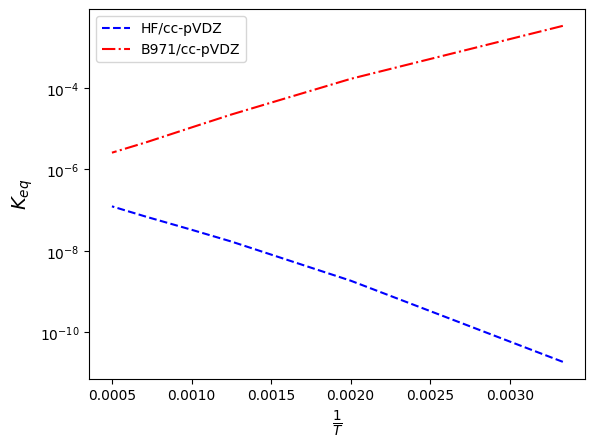

In [ ]:
from matplotlib import pyplot as plt
#plot the equilibrium constant as a function of temperature for both levels of theory.
T_invs = [1/T for T in Ts]
plt.figure()
plt.plot(T_invs, eq_rs ,'b--', label = 'HF/cc-pVDZ')
plt.plot(T_invs, eq_dft_rs ,'r-.', label = 'B971/cc-pVDZ')
plt.legend()
plt.yscale('log')
plt.xlabel(r"$\frac{1}{T}$", fontsize = 14)
plt.ylabel("$K_{eq}$", fontsize = 14)
plt.show()